In [3]:
import os

from tqdm import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

class BaseArticleDataset:
    def __init__(self, data_dir: str = 'data', language: str = 'en', subtask: int = 2, split: str = 'train'):
        self.language = language
        self.subtask = subtask
        self.split = split
        self.label_file_path = os.path.join(data_dir, language, f'{split}-labels-subtask-{subtask}.txt')
        self.article_dir_path = os.path.join(data_dir, language, f'{split}-articles-subtask-{subtask}')
        self.df = self._create_article_dataframe()

    def _create_article_dataframe(self) -> pd.DataFrame:
        text = []

        for fil in tqdm(filter(lambda x: x.endswith('.txt'), os.listdir(self.article_dir_path))):
            id, txt = fil[7:].split('.')[0], \
                      open(os.path.join(self.article_dir_path, fil), 'r', encoding='utf-8').read()
            text.append((id, txt))

        return pd.DataFrame(text, columns=['id', 'raw_text']) \
            .astype({'id': 'int', 'raw_text': 'str'}) \
            .set_index('id')

    def separate_title_content(self, remove_raw_data_col: bool = False) -> None:
        # TODO: Improve behavior by:
        #   1) Remove trailing whitespaces and breaklines
        #   2) Separate on single breakline "\n"
        #   3) Remove trailing whitespaces and breaklines for title and content again
        self.df[['title', 'content']] = self.df.raw_text.str.split('\n\n', 1, expand=True)

        if remove_raw_data_col:
            self.df.drop('raw_text', axis=1, inplace=True)

# Load the Data

In [4]:
semeval_data = BaseArticleDataset(
    data_dir=os.path.join('..', '..', 'data'),
    language='en', subtask=2, split='train')

433it [00:00, 7277.66it/s]


In [5]:
semeval_data.df

,raw_text
id,
765982381,Julian Assange\n\nDuring World War II Cardinal...
766942310,Who ‘Won’ the Trump-Kim Summit?\n\nLast week’s...
706777811,Black Death: ‘It’s 100 % Likely’ It Spreads To...
779394730,"Hundreds of Priests Accused in Pennsylvania, C..."
758472954,"Beware sonic weapon attacks, US tells citizens..."
...,...
761334950,A Dismal Record: Why Are They Destroying the N...
833042063,Chelsea Handler Admits She’s ‘Very Sexually At...
999000145,"Trump: ""If You Don't Want To Be Saying The Wor..."


# Summary of findings

 * Articles seem to come from fringe rather unreliable sources of news. This is probably because they reflect a specific frame and bias in it more strongly
 * There are minor errors in the dataset such as:
    * Some titles are not appropriately parsed with "\n\n".
    * Some articles are duplicated.
    * Some articles also contain not relevant text such as text from banners or sponsored articles within the article (see article 999001280 in english).
 * It should be possible to separate title and content with the following steps:
    * Remove trailing whitespaces and breaklines
    * Separate on single breakline "\n"
    * Remove trailing whitespaces and breaklines for title and content again
 * Russian articles seem to be better parsed and structured.
    * For example, it is possible to separate title, subtitle, and content
    * Also seems to be better split into paragraphs, which happens much less often for english and italian.
 * For many articles, a breakline identifies a change of paragraph. However, this patterns does not always hold for some exceptions.
    * A solution when we need the whole paragraph would be to merge the first two paragraphs when the first one is only one sentece long and that sentence is short.
 * For some articles, the order of the paragraph is wrong due to the structure of the website
    * [730019938](https://vdare.com/posts/suspect-in-westerville-oh-murder-of-two-white-cops-named-as-quentin-lamar-smith-apparently-black)
    * [725276027](https://vdare.com/posts/kritarchs-patti-saris-and-mark-goldsmith-sabotage-immigration-enforcement)
    * [711716996](https://vdare.com/posts/patti-saris-strikes-again-indonesian-illegals-who-have-been-here-since-the-90s-get-to-say)


# Sample texts and check structure

## Verify all titles are properly separated

In [6]:
semeval_data.separate_title_content()

Text(0.5, 0, 'length')

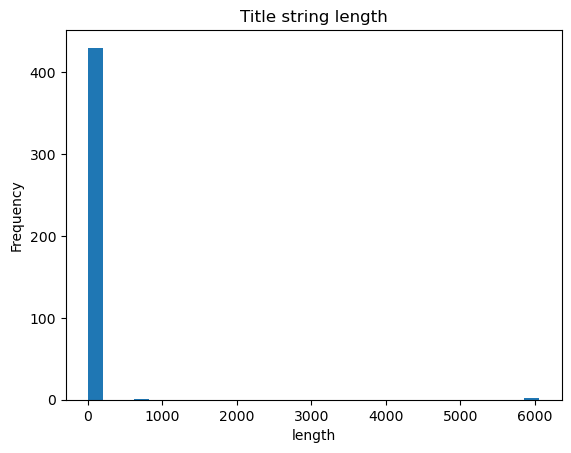

In [7]:
semeval_data.df.title.str.len().plot.hist(bins=30, title="Title string length")
plt.xlabel('length')

There is at least a couple of articles with overly long titles, most likely not properly parsed

Text(0.5, 0, 'length')

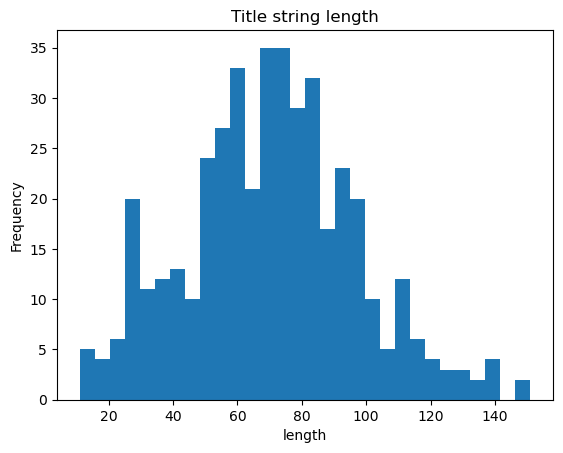

In [8]:
max_title_length = semeval_data.df.title.str.len().quantile(0.99)
max_title_length

semeval_data.df.title[semeval_data.df.title.str.len() < max_title_length]\
    .str.len().plot.hist(bins=30, title="Title string length")
plt.xlabel('length')

This seems a bit more expected. Let's check samples on quartiles and verify if they are indeed titles or not

In [46]:
pd.DataFrame(semeval_data.df.title[semeval_data.df.title.str.len() >= max_title_length])

,title
id,
704856340,New Audio From The Night Of The Las Vegas Mass...
999000878,Las Vegas Shooting: A THIRD Timeline Emerges E...
698092698,Las Vegas Shooting: A THIRD Timeline Emerges E...
764715911,After Calling for Guns & Ammo Confiscation & U...
725824328,America's Immigration Voice. From TPM: The Pho...


In [10]:
semeval_data.df.raw_text.loc[725824328]

"America's Immigration Voice. From TPM: The Photo That Never Saw\nThe Light of Day: Obama With Farrakhan In 2005 By Esme Cribb | January 25, 2018\n2:16 pm A journalist announced last week that he will publish a photograph of\nthen-IllinoisSen. Barack Obamaa (D) and Nation of Islam leader Louis Farrakhan that\nhe took in 2005 at a Congressional Black Caucus meeting, but did not make\npublic because he believed it would have “made a difference” to Obama’s\npolitical future. The photographer, Askia\nMuhammad, told the Trice Edney News Wire that he “gave the picture up at the\ntime and basically swore secrecy.”“But after the nomination was secured and all the way up until the inauguration; then for eight years after he was President, it was kept under cover,”  Muhammad said. \n\nAsked whether he thought the photo’s release would\nhave affected Obama’s presidential campaign, Muhammad said, “I insist. It\nabsolutely would have made a difference.” Reached by TPM on Thursday, Muhammad\nsaid a 

In [11]:
semeval_data.df.title.loc[725824328]

"America's Immigration Voice. From TPM: The Photo That Never Saw\nThe Light of Day: Obama With Farrakhan In 2005 By Esme Cribb | January 25, 2018\n2:16 pm A journalist announced last week that he will publish a photograph of\nthen-IllinoisSen. Barack Obamaa (D) and Nation of Islam leader Louis Farrakhan that\nhe took in 2005 at a Congressional Black Caucus meeting, but did not make\npublic because he believed it would have “made a difference” to Obama’s\npolitical future. The photographer, Askia\nMuhammad, told the Trice Edney News Wire that he “gave the picture up at the\ntime and basically swore secrecy.”“But after the nomination was secured and all the way up until the inauguration; then for eight years after he was President, it was kept under cover,”  Muhammad said. "

According to this [website](https://sigforum.com/eve/forums/a/tpc/f/320601935/m/3550057634), the actual title is: **"The Photo That Never Saw The Light of Day: Obama With Farrakhan In 2005"**. Hard to tell the delimiter for this case

In [12]:
semeval_data.df.title.loc[764715911]

'After Calling for Guns & Ammo Confiscation & Universal Gun Registration, the American Medical Association Should Think About Taking "American" Out of Their Name'

According to this [website](http://www.invexnews.com/item-361622-after-calling-for-guns-amp-ammo-confisca) the title is correct

In [13]:
semeval_data.df.title[704856340]

'New Audio From The Night Of The Las Vegas Massacre Reveals That There Was “Another Active Shooter” In The Bar At The Top Of The Mandalay Bay Hotel During The Attack'

Again another long title, but it seems correct.

In [14]:
semeval_data.df.title[698092698]

"Las Vegas Shooting: A THIRD Timeline Emerges Editor's Note: This is\nprobably a reason why reporters Laura Loomer and Mike Tokes were barred from\nentering the presser. They would have posed real genuine questions of Sheriff\nLombardo and forced him to stumble all over himself in answering them. The words\n“conspiracy theorists” are being bandied about. Are they for real? A well-coordinated, meticulously planned attack on\nconcertgoers leads to the murder of 58 Americans at a country music festival in\nLas Vegas, with over 500 injured, and they have no explanation or motive. Do the FBI and law enforcement think people won’t talk about\nit or speculate as to what happened? Are they for real? Further, the FBI\ninsists there is no jihad motive, while saying they don’t know his motive.\nHow can they possibly hold those two contradictory ideas at the same time? The\nsheriff, alluding to allegations of a conspiracy between his department, the\nF.B.I., and MGM — supposedly in an effort to es

In [15]:
semeval_data.df.title[999000878]

"Las Vegas Shooting: A THIRD Timeline Emerges Editor's Note: This is\nprobably a reason why reporters Laura Loomer and Mike Tokes were barred from\nentering the presser. They would have posed real genuine questions of Sheriff\nLombardo and forced him to stumble all over himself in answering them. The words\n“conspiracy theorists” are being bandied about. Are they for real? A well-coordinated, meticulously planned attack on\nconcertgoers leads to the murder of 58 Americans at a country music festival in\nLas Vegas, with over 500 injured, and they have no explanation or motive. Do the FBI and law enforcement think people won’t talk about\nit or speculate as to what happened? Are they for real? Further, the FBI\ninsists there is no jihad motive, while saying they don’t know his motive.\nHow can they possibly hold those two contradictory ideas at the same time? The\nsheriff, alluding to allegations of a conspiracy between his department, the\nF.B.I., and MGM — supposedly in an effort to es

This reveals a second problem of duplicates documents in the dataset :O

According to the this [website](https://investortimes.com/freedomoutpost/las-vegas-shooting-third-timeline-emerges/) the full title is: "**Las Vegas Shooting: A THIRD Timeline Emerges**".

**Overall, we can fix the problem with some noise by separating very long with "\n" instead of "\n\n", or hard code the titles for these articles**

### Check title length behavior in Russian and Italian

In [16]:
semeval_data_ru = BaseArticleDataset(
    data_dir=os.path.join('..', '..', 'data'),
    language='ru', subtask=2, split='train')
semeval_data_ru.separate_title_content()

semeval_data_it = BaseArticleDataset(
    data_dir=os.path.join('..', '..', 'data'),
    language='it', subtask=2, split='train')
semeval_data_it.separate_title_content()

143it [00:00, 6036.25it/s]
227it [00:00, 6733.53it/s]


In [17]:
print(semeval_data.df.shape)
print(semeval_data_ru.df.shape)
print(semeval_data_it.df.shape)

(433, 3)
(143, 3)
(227, 3)


Text(0.5, 0, 'length')

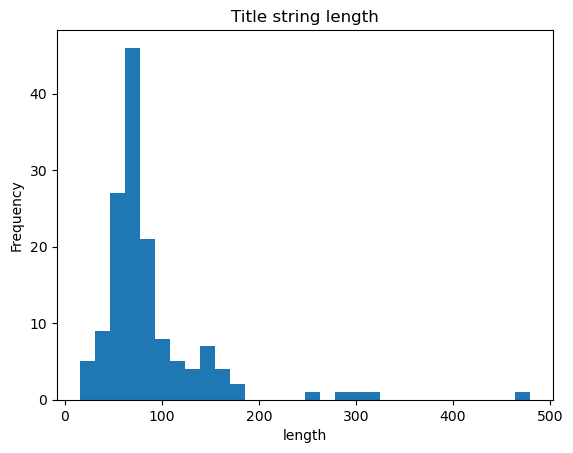

In [18]:
semeval_data_ru.df.title.str.len().plot.hist(bins=30, title="Title string length")
plt.xlabel('length')

Text(0.5, 0, 'length')

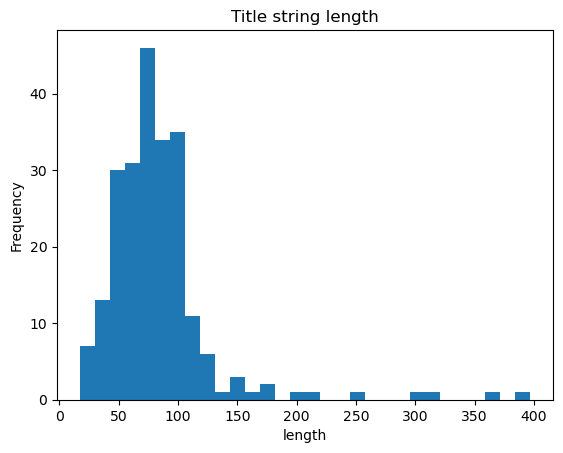

In [19]:
semeval_data_it.df.title.str.len().plot.hist(bins=30, title="Title string length")
plt.xlabel('length')

Let's check title that contain breaklines or that are over 150 lines characters long

In [20]:
semeval_data_it.df[semeval_data_it.df.title.str.contains('\n')]

,raw_text,title,content
id,,,
26303,"Russia, “Bloomberg”: il G7 fatica a trovare al...","Russia, “Bloomberg”: il G7 fatica a trovare al...",Gli sforzi degli Usa e del G7 per guadagnare i...
26243,\nAL VOTO! AL VOTO! I POLITICI PAROLAI\n\nANTO...,\nAL VOTO! AL VOTO! I POLITICI PAROLAI,ANTONIO PADELLARO MARCO TRAVAGLIO FURIO COLOMB...
2660,"Caro Draghi, sono i vaccinati a intasare le te...","Caro Draghi, sono i vaccinati a intasare le te...",Nel tentativo di fomentare l’odio sociale cont...
26302,Estonia: il governo decide di rimuovere tutti ...,Estonia: il governo decide di rimuovere tutti ...,Il governo dell’Estonia ha deciso a favore del...
26301,Per Mosca dietro il Covid e il vaiolo delle sc...,Per Mosca dietro il Covid e il vaiolo delle sc...,AGI - L'esercito russo ritiene che dietro il C...
26294,Coinvolgere i boomerIl movimento per il clima ...,Coinvolgere i boomerIl movimento per il clima ...,"Ok, boomer? L’idea potremmo tradurla così: rib..."
26127,"\n""Non siamo sotto l'ombrello della Nato. Siam...","\n""Non siamo sotto l'ombrello della Nato. Siam...","Chiedo venia per portare notizie funeste, ma a..."
2661,"Spagna a braccia aperte, Madrid accoglie i mig...","Spagna a braccia aperte, Madrid accoglie i mig...",A braccia aperte. La Spagna è in trattativa co...


In [21]:
semeval_data_it.df[(semeval_data_it.df.title.str.len() > 150) & (semeval_data_it.df.title.str.contains('\n'))]

,raw_text,title,content
id,,,
26303,"Russia, “Bloomberg”: il G7 fatica a trovare al...","Russia, “Bloomberg”: il G7 fatica a trovare al...",Gli sforzi degli Usa e del G7 per guadagnare i...
2660,"Caro Draghi, sono i vaccinati a intasare le te...","Caro Draghi, sono i vaccinati a intasare le te...",Nel tentativo di fomentare l’odio sociale cont...
26302,Estonia: il governo decide di rimuovere tutti ...,Estonia: il governo decide di rimuovere tutti ...,Il governo dell’Estonia ha deciso a favore del...
26301,Per Mosca dietro il Covid e il vaiolo delle sc...,Per Mosca dietro il Covid e il vaiolo delle sc...,AGI - L'esercito russo ritiene che dietro il C...
26294,Coinvolgere i boomerIl movimento per il clima ...,Coinvolgere i boomerIl movimento per il clima ...,"Ok, boomer? L’idea potremmo tradurla così: rib..."
2661,"Spagna a braccia aperte, Madrid accoglie i mig...","Spagna a braccia aperte, Madrid accoglie i mig...",A braccia aperte. La Spagna è in trattativa co...


In [22]:
print(semeval_data_it.df.title[26294])

Coinvolgere i boomerIl movimento per il clima non può rimanere solo una storia di ragazzini
75 milioni: è il numero di over 60 negli Stati Uniti. Sono più di tutta la popolazione italiana, votano in grandi numeri e possiedono i due terzi delle risorse finanziarie del Paese. È per questo che Bill McKibben ha fondato un nuovo movimento, chiamato Third Act, rivolto alla mobilitazione degli anziani


According to this [website](https://www.linkiesta.it/2022/07/third-act-anziani-attivismo-clima-ambiente/) the title is the first line

In [23]:
print(semeval_data_it.df.title[26301])

Per Mosca dietro il Covid e il vaiolo delle scimmie potrebbero esserci gli Usa
Il tenente comandante delle forze di protezione chimica, biologica contro le radiazioni della Difesa: "L'impressione è che la pandemia sia artificialmente potenziata con nuove varianti rilasciate in una regione o nell'altra"


According to this [website](https://www.agi.it/estero/news/2022-08-04/mosca-dietro-covid-vaiolo-scimmie-gli-usa-17660932/), again the title is the first line

It stands to reason then that the following two steps should yield the right separation of title and content for Italian and English

 * Remove trailing whitespaces and breaklines
 * Separate on single breakline "\n"
 * Remove trailing whitespaces and breaklines for title and content again


In [24]:
semeval_data_ru.df[(semeval_data_ru.df.title.str.len() > 150) & (semeval_data_ru.df.title.str.contains('\n'))]

,raw_text,title,content
id,,,
2444,"Владимир Путин: Наш долг – помнить, что на сов...","Владимир Путин: Наш долг – помнить, что на сов...",Владимир Путин много раз принимал Парад Победы...
24180,Перечень недружественных России стран пополнил...,Перечень недружественных России стран пополнил...,Российское правительство обновило перечень ино...
24172,"Александра Архипова. Что будет, если в России ...","Александра Архипова. Что будет, если в России ...","В российской Госдуме готовят законопроект, сог..."
24177,Дугин впервые прокомментировал убийство дочери...,Дугин впервые прокомментировал убийство дочери...,Философ Александр Дугин назвал терактом гибель...
24173,Оскандалившаяся Трасс дала ряд обещаний избира...,Оскандалившаяся Трасс дала ряд обещаний избира...,"Глава британского МИД Лиз Трасс, с чьим именем..."
2447,Посол Украины обвинил ФРГ в отсутствии должног...,Посол Украины обвинил ФРГ в отсутствии должног...,Власти Германии не оказывают украинским беженц...
2462,Эксперт предсказал реакцию России на попытки Н...,Эксперт предсказал реакцию России на попытки Н...,"МОСКВА, 20 июн — РИА Новости. Гипотетические п..."
2480,Что на самом деле произошло в Кременчуге\nВ ре...,Что на самом деле произошло в Кременчуге\nВ ре...,"Российские чиновники сперва заявили, что это «..."
24103,Зеленский последние новости\nК 1 сентября Укра...,Зеленский последние новости\nК 1 сентября Укра...,"При этом он ссылается на собственные подсчеты,..."


In [25]:
print(semeval_data_ru.df.title[2444])

Владимир Путин: Наш долг – помнить, что на советский народ пришлась основная тяжесть борьбы с нацизмом
Президент России принял Парад потомков Поколения победителей


In [26]:
print(semeval_data_ru.df.raw_text[2444])

Владимир Путин: Наш долг – помнить, что на советский народ пришлась основная тяжесть борьбы с нацизмом
Президент России принял Парад потомков Поколения победителей

Владимир Путин много раз принимал Парад Победы, но Парад в честь 75-летия победы в Великой Отечественной войне стал одним из самых сложных и ответственных для президента России. Эпидемия коронавируса сначала заставила сдвинуть дату проведения Парада, потом наложила сверхсложные ограничения, помешала очень многим из тех, кто хотел приехать на праздник из других стран. Но самого главного отменить она не смогла.

- Поздравляю вас с 75-й годовщиной Победы в Великой Отечественной войне! Победы, которая определила будущее планеты на десятилетия вперёд и навсегда осталась в истории как самая грандиозная по своему масштабу, значению и по духовной, нравственной высоте, - обратился к собравшимся на Красной площади Путин.

На одной трибуне с президентом России находились приехавшие в Москву президенты Абхазии, Белоруссии, Казахстана, 

For this [article](https://www.kp.ru/daily/27147/4241476/) it actually seems to be well parsed and that the second line of the title is in fact a subtitle

In [27]:
print(semeval_data_ru.df.raw_text[24109])


АРНО ХИДИРБЕГИШВИЛИ: ГРУЗИЯ ДОЛЖНА РАЗОРВАТЬ ДИПОТНОШЕНИЯ С УКРАИНОЙ!
   «Почему, несмотря на все сложности российско-грузинских отношений, премьер-министр Грузии Ираклий Гарибашвили в очередной раз подтвердил, что официальный Тбилиси будет сохранять нейтралитет относительно ситуации на Украине?» - спросил постоянный ведущий программы «Мнение» на телеканале «News Front» Алексей Давыдов Главного редактора информационно-аналитического агентства «Грузинформ» Арно Хидирбегишвили.

Арно Хидирбегишвили: «Становление Гарибашвили как менеджера состоялось в бизнес-структуре миллиардера Бидзины Иванишвили, поэтому, став премьер-министром, он мыслит как бизнесмен, прагматичными категориями, в тоже время являясь патриотом своей страны и ответственным политиком. А главный принцип Бидзина Иванишвили после прихода в политику озвучил сам 1 ноября 2012 года, на своей первой пресс-конференции, и звучит он так: «Всё, что в интересах Грузии». Так ответил Иванишвили на вопрос журналиста - может ли Грузия в

Russian articles are well parsed and usually a breakline indicates the presence of a subtitle (was often the case for the articles in the previous list). For russian, the previous preprocessing of the other two languages is not as much a necessity, though it still separates title from subtitle

## Check for other long titles and verify further quality of parsing

In [45]:
pd.DataFrame(semeval_data.df.title[semeval_data.df.title.str.len().between(120, max_title_length)])

,title
id,
787142429,Brett Kavanaugh accused in letter obtained by ...
999000135,CNN's Don Lemon Contradicts Himself In Just On...
999000133,Don Lemon Is Lying... Again: Biggest Threat Is...
786527921,‘Silent Donation’: Corporate Emails Reveal Goo...
761968851,National Data | December Jobs—TRUMP EFFECT! Am...
718312499,New Footage From Las Vegas Massacre Reveals Po...
703806098,There Were “Active Shooters On The Runway” Bom...
788626289,‘Emotional And Physical Abuse’: Muslim Brother...
706636401,Newly Released Private Surveillance Footage Fr...


In [29]:
semeval_data.df.title[999000135]

'CNN\'s Don Lemon Contradicts Himself In Just One Sentence: "We Have to Stop Demonizing People ... White Men, Most Of Them Radicalized"'

In [30]:
print(semeval_data.df.raw_text[999000135])

CNN's Don Lemon Contradicts Himself In Just One Sentence: "We Have to Stop Demonizing People ... White Men, Most Of Them Radicalized"

Talk about an absolute hypocrite! However, it comes as no surprise from a hypocrite who works for a hypocritical, lying, fake news outlet like CNN. Don Lemon wanted to defend the "peaceful" migrants who are headed toward the US border to illegally enter the country against our immigration laws, but said that the "biggest terror threat in this country is white men, most of them radicalized to the right." How can he contradict himself like that and not even bat an eyelid?
In discussing the arrival of these migrants who obviously gotten incredible help along the way, busted through customs gates, and pushed at the Mexican border while committing all sorts of crimes against many they come in contact with along the way, Lemon said what is clearly not only racist but utterly insane.
"We have to stop demonizing people and realize the biggest terror threat in t

In [31]:
semeval_data.df.title[999000133]

'Don Lemon Is Lying... Again: Biggest Threat Isn\'t "White Men" - The FBI\'s Most Wanted Domestic Terrorists Are These People'

In [32]:
print(semeval_data.df.raw_text[999000133])

Don Lemon Is Lying... Again: Biggest Threat Isn't "White Men" - The FBI's Most Wanted Domestic Terrorists Are These People

“So, we have to stop demonizing people and realize the biggest terror threat in this country is white men, most of them radicalized to the right. And we have to start doing something about them. There is no travel ban on them. There is no ban on — they had the Muslim ban. There is no white guy ban. So, what do we do about that?” –Don Lemon
Just to illustrate the absurdity of Don Lemon’s comments, I thought it would be fun to go look at the current list of the FBI’s most wanted terrorists. Below is the list of “domestic” terrorists and, regardless of the list/filter you choose, you won’t find many “white men”.
Interestingly enough, it looks like the WOMEN in this country are currently responsible for more terrorism than WHITE MEN. Mr. Lemon, you are very wrong.
Below are the 14 profiles currently listed as the “Most Wanted Domestic Terrorists”
take our poll - story

In [33]:
semeval_data.df.title[999001280]

'Hey, Self Proclaimed "Fact Checkers" and Mainstream Media, Let\'s Not Let That Jim Acosta Propaganda You\'re Putting Out Go So Fast!'

In [34]:
print(semeval_data.df.raw_text[999001280])

Hey, Self Proclaimed "Fact Checkers" and Mainstream Media, Let's Not Let That Jim Acosta Propaganda You're Putting Out Go So Fast!

Notice how quickly the drive-by media and self-proclaimed "fact checkers" gunned down the Trump administration and Infowars with their lying propaganda over the video that was enhanced, not doctored, to demonstrate that all of them and Jim Acosta are lying through their Communist teeth? Yep, I noticed too, and now they're trying to move on, but I'm gonna get in one last bit before we do.
Of course, Infowars' Paul Joseph Watson simply enhanced the video from C-SPAN, which was a gif image (motion picture), in order to show the point of contact that the lying media and "fact checkers" said didn't occur.
Watson then went on to be happy that President Trump backed him up on his comments about the video. Take a look, and as always, PJW is hilarious in his presentation.
If they're prepared to lie this shamelessly, what else are they lying about? take our poll - s

Everything seems ok

## Check for titles that contain breaklines (possibly badly parsed articles)

In [35]:
semeval_data.df[semeval_data.df.title.str.contains('\n')]

,raw_text,title,content
id,,,
999000878,Las Vegas Shooting: A THIRD Timeline Emerges E...,Las Vegas Shooting: A THIRD Timeline Emerges E...,None
698092698,Las Vegas Shooting: A THIRD Timeline Emerges E...,Las Vegas Shooting: A THIRD Timeline Emerges E...,\n
725824328,America's Immigration Voice. From TPM: The Pho...,America's Immigration Voice. From TPM: The Pho...,Asked whether he thought the photo’s release w...


The only ones that have breaklines are the ones we had already identified

# Check if there is a pattern of paragraph structure

It seems like each breakline follows the paragraph structure of the source document and how it is presented in the website. However, there are some issues with this parsing and the pattern not always holds:

### Do breaklines identifyy separate paragraphs

This seems to be the case for the following examples

   * [765982381](https://www.newagebd.net/print/article/43964)
   * [725276027](https://vdare.com/posts/kritarchs-patti-saris-and-mark-goldsmith-sabotage-immigration-enforcement)
   * [738542398](https://theintercept.com/2017/02/02/trumps-cia-chief-selects-major-torture-operative-to-be-agencys-deputy-director/)
   * Correct but first paragraph is not really a paragraph [765029945](https://bluntforcetruth.com/news/stop-comparing-immigration-enforcement-to-the-holocaust/)


It is not the case for the following examples
   * [765385479](https://www.wsws.org/en/articles/2018/06/19/john-j19.html)
   * [832959523](https://www.moonofalabama.org/2019/03/how-theresa-may-botched-brexit.html): Again, a weird parsing or separation of sentences
   * [999000878](https://investortimes.com/freedomoutpost/las-vegas-shooting-third-timeline-emerges/): Terrible parsing of sentences and paragraphs

A solution when we need the whole paragraph would be to merge the first two paragraphs when the first one is only one sentece long and that sentence is short.

### Document has the wrong order

Compare the document in the [website](https://vdare.com/posts/impeach-kritarch-patti-saris-for-illegally-trying-to-stop-deportations) and the one in the dataset.

In [41]:
print(semeval_data.df.loc[702111021].raw_text)

America's Immigration Voice.

Kritarch Patti Saris is in the news again. She is one of many Federal District Court Judges who want to run immigration policy, despite the fact that the Constitution gives authority over immigration to Congress, and Congress has allocated considerable authority to the President. This writer exposed her attempted violation of the Constitution after she initially stopped the deportation of a number of Indonesians back to Indonesia as she saw it unjust and decided to substitute her moral judgment for the laws of the United States.
Kritarch Patti Saris
Federal courts do not have direct authority over immigration matters, which are handled by the Executive Office for Immigration Review, but Chief Judge Patti Saris of the US District Court in Boston wrote in a court filing on Wednesday that she has a say over the terms of his confinement. US Judge Rejects Bid to Dismiss Indonesian Immigrant's Lawsuit, Jakarta Globe/Reuters, October 25, 2017
"The district court 

The paragraphs are clearly out of order and the title was not parsed. It is possible this website had a different structure resulting in the wrong parsing of the article. The same holds for all articles of that website:

 - [730019938](https://vdare.com/posts/suspect-in-westerville-oh-murder-of-two-white-cops-named-as-quentin-lamar-smith-apparently-black)
 - [725276027](https://vdare.com/posts/kritarchs-patti-saris-and-mark-goldsmith-sabotage-immigration-enforcement)
 - [711716996](https://vdare.com/posts/patti-saris-strikes-again-indonesian-illegals-who-have-been-here-since-the-90s-get-to-say)